# Exploratory Data Analysis

This section investigates patterns and relationships among the vessels that did not appear in the IMO database. 

## Data Dictionary

| Column | Datatype | Description |
|---------------------------|----------|-------------------------------------------------------------------------------------------------------|
| ssvid | int64 | the vessel's MMSI code which is it's "unique" AIS ID |
| gap_hours | float64 | length of the gap event |
| gap_distance_m | float64 | distance of the gap event in miles |
| gap_implied_speed_knots | float64 |  |
| positions_per_day | float64 |  |
| vessel_class | object | vessel geartype |
| flag | object | The state a vessel is registered or licensed under |
| off_timestamp | object | timestamp AIS was turned off |
| off_msgid | object | message ID from AIS turning off |
| off_lat | float64 | latitude when AIS turned off |
| off_lon | float64 | longitude when AIS turned off |
| off_type | object | the class of AIS device (A or B), Class A devices are more expensive, have stronger signals and broadcast more frequently |
| off_receiver_type | object | whether the AIS message was recieved by a satellite or terrestrial receiver when turned off |
| off_distance_from_shore_m | float64 | distance from shore when AIS turned off |
| on_timestamp | object | timestamp AIS was turned on |
| on_msgid | object | message ID from AIS turning on |
| on_lat | float64 | latitude when AIS turned on |
| on_lon | float64 | longitude when AIS turned on |
| on_type | object | the class of AIS device (A or B), class A devices have stronger signals and broadcast more frequently |
| on_receiver_type | object | whether the AIS message was recieved by a satellite or terrestrial receiver when turned on |
| on_distance_from_shore_m | float64 | distance from shore when AIS turned on |

## Import Packages and Data

In [126]:
# standard data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [175]:
# import IMO non registered list and gap events dataset
imo_notreg = pd.read_csv('./data/imo_notreg.csv')
gap_events = pd.read_csv('./data/raw_sample.csv') 

In [177]:
# check the contents
print(f'Total Non-Registered Vessels: {len(imo_notreg)}')
print(f'Gap Events: {len(gap_events)}')

Total Non-Registered Vessels: 79066
Gap Events: 500000


In [178]:
imo_notreg['0'].nunique()

43168

In [179]:
# Confirm highest number of times a vessel appears
imo_notreg['0'].value_counts()

563022450    14
431008005    13
416005616    12
228208700    12
224220130    11
             ..
100899415     1
412479697     1
225985132     1
412283514     1
412352512     1
Name: 0, Length: 43168, dtype: int64

## Combine and Clean Datasets

In [180]:
# Filter the full gap events dataset to only include the non registered vessels
gap_notreg = gap_events[gap_events['ssvid'].isin(imo_notreg['0'])]
gap_notreg.shape

(346762, 21)

In [181]:
# change ssvid column name for consistency
gap_notreg = gap_notreg.rename(columns={'ssvid':'mmsi'})
gap_notreg.head()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,off_type,off_receiver_type,off_distance_from_shore_m,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m
0,412422839,39.433333,535.624620,0.007334,0.034917,fishing,CHN,2018-11-02T08:32:54Z,ab04ae1f-022d-1cf8-6704-79f5c18f03fe,29.940583,...,B,terrestrial,0.0,2018-11-03T23:59:40Z,d66f5755-1e80-50b7-9c24-97affcd0d30b,29.938277,122.273638,B,terrestrial,1000.0
1,247143160,80.800000,1260.751756,0.008425,2.947519,trawlers,ITA,2018-05-18T18:22:40Z,a08e856c-e011-5dab-8ae8-03a4bf0c7ba1,38.099993,...,A,terrestrial,0.0,2018-05-22T03:11:32Z,97e47f62-0784-5e70-bea4-b57c23dcab63,38.088952,13.540445,A,terrestrial,0.0
2,224231150,15.816667,9683.318918,0.330574,0.115448,set_gillnets,ESP,2018-03-22T11:28:05Z,b4fbb421-1944-5a5f-b3ae-aabb589bb8d3,43.406192,...,B,terrestrial,3000.0,2018-03-23T03:17:34Z,7137847e-305e-5a4f-8b82-ab83b181c4ab,43.354105,-8.375345,B,terrestrial,1000.0
3,413002111,14.433333,2965.614746,0.110945,0.416022,trawlers,CHN,2018-02-28T19:59:57Z,06e02215-e3b7-59ac-8504-f404fc25196c,26.573672,...,A,terrestrial,42000.0,2018-03-01T10:26:32Z,499bb4b5-a209-5f79-9718-ea361000bbdc,26.564128,120.902237,A,terrestrial,44000.0
4,247074840,16.450000,495.809447,0.016275,0.538665,trawlers,ITA,2018-04-25T07:43:16Z,248c64e1-6d7b-5553-bffe-8974fc455332,44.675090,...,A,terrestrial,0.0,2018-04-26T00:10:43Z,5659fa33-6771-584a-95a5-4d35df3f544f,44.675367,12.235438,A,terrestrial,0.0


In [182]:
gap_notreg.describe()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,off_lat,off_lon,off_distance_from_shore_m,on_lat,on_lon,on_distance_from_shore_m
count,3.467620e+05,346762.000000,3.467620e+05,346762.000000,344906.000000,346762.000000,346762.000000,3.467540e+05,346762.000000,346762.000000,3.467560e+05
mean,4.134220e+08,125.473019,2.873190e+04,0.414658,11.761397,31.890658,90.835906,1.838358e+04,31.893232,90.844197,1.865638e+04
std,1.803360e+08,429.313197,1.693180e+05,3.504960,41.770756,12.703357,57.082368,7.212948e+04,12.698465,57.077196,7.240180e+04
min,1.114720e+05,12.000000,0.000000e+00,0.000000,0.000000,-89.977667,-179.833372,0.000000e+00,-89.929540,-179.909047,0.000000e+00
25%,2.774402e+08,16.733333,3.407681e+02,0.003546,0.001704,24.832000,109.011728,0.000000e+00,24.840870,109.005823,0.000000e+00
50%,4.124257e+08,30.550000,3.613040e+03,0.044143,0.051323,31.008883,119.521981,2.000000e+03,31.038048,119.530272,2.000000e+03
75%,4.160017e+08,83.016667,1.703127e+04,0.237987,1.785874,37.930020,121.949576,1.300000e+04,37.930048,121.953170,1.300000e+04
max,1.020002e+09,15511.116667,1.919246e+07,617.980208,735.613968,72.965227,179.995645,1.994000e+06,72.889147,179.999600,2.002000e+06


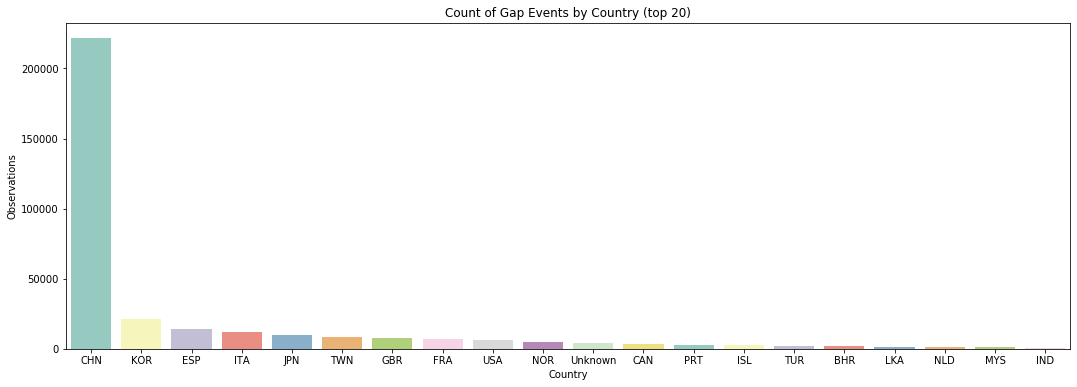

In [245]:
# Check which countries have the most gap events?

plt.figure(figsize=(18,6))
countries = sns.countplot(x="flag", data=gap_notreg, palette="Set3",
              order=gap_notreg['flag'].value_counts().iloc[:20].index).set(xlabel='Country',
                                                                           ylabel='Observations',
                                                                           title='Count of Gap Events by Country (top 20)');

# for bar in countries.patches:
#     countries.annotat(format(bar.get_height(), '.2f'), 
#                       (p.get_x() + p.get_width() / 2., 
#                        p.get_height()), 
#                        ha = 'center',  
#                        va = 'center', 
#                        xytext = (0, 10), 
#                        textcoords = 'offset points')
    
    

In [219]:
# Check for duplicate rows
duplicates = gap_notreg.duplicated()
gap_notreg[duplicates].head()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,off_receiver_type,off_distance_from_shore_m,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m,off_cluster


In [210]:
# Drop duplicate rows
gap_notreg = gap_notreg.drop_duplicates()

In [184]:
# Change time columns to datetime
gap_notreg['off_timestamp'] = pd.to_datetime(gap_notreg['off_timestamp'], format='%Y-%m-%d %H:%M:%S')
gap_notreg['on_timestamp'] = pd.to_datetime(gap_notreg['on_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [185]:
# Check timeframe
gap_notreg['off_timestamp'].min(), gap_notreg['off_timestamp'].max()

(Timestamp('2018-01-01 00:05:37+0000', tz='UTC'),
 Timestamp('2019-12-31 09:48:32+0000', tz='UTC'))

# DBSCAN Model: Clustering Coordinates Where Vessels Go Dark

The popular clustering algorithm DBSCAN is a useful tool for exploration at this stage because it creates clusters by linking nearby data points to one another. I will feed in the location data at the moment vessels go dark (turn off their AIS transponders).

The latitude and longitude coordinates must be [converted from degrees to radians](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/) in order to use Scikit-Learn's haversine distance metric. The algorithm uses an epsilon value (distance threshold) of 20 km, which is also converted to radian units. Min samples are set at 40 as it seemed reasonable to assume that 40 instances of a vessel going dark within a 20 km radius is indicative of suspicious behavior. Scaling is not required since the data is in latitude longitude coordinates. **Add comment on ball tree algorithm**

## Prepare Latitude and Longitude Data

In [136]:
# Make a dataframe of only lat/lon at AIS switch off

latlon_off = gap_notreg[['off_lat', 'off_lon']]
latlon_on = gap_notreg[['on_lat', 'on_lon']]

latlon_off.head()

,off_lat,off_lon
0,29.940583,122.278518
1,38.099993,13.543718
2,43.406192,-8.471367
3,26.573672,120.874392
4,44.675090,12.241697


In [137]:
latlon_on.head()

,on_lat,on_lon
0,29.938277,122.273638
1,38.088952,13.540445
2,43.354105,-8.375345
3,26.564128,120.902237
4,44.675367,12.235438


In [138]:
# convert columns to numpy matrices
off_coords = latlon_off.to_numpy()
on_coords = latlon_on.to_numpy()

# check array
off_coords

array([[ 29.94058333, 122.27851833],
       [ 38.09999333,  13.54371833],
       [ 43.40619167,  -8.47136667],
       ...,
       [ 24.60301833, 119.626755  ],
       [ 38.79213667, 121.40220333],
       [ 37.69489667, 121.143345  ]])

In [139]:
# convert epsilon and coordinates to radians 
# code adapted from Geoff Boeing
kms_per_radian = 6371.0088
epsilon = 20 / kms_per_radian 

off_coords = np.radians(off_coords)
on_coords = np.radians(on_coords)

# check array
off_coords

array([[ 0.52256176,  2.13416275],
       [ 0.66497033,  0.23638248],
       [ 0.75758096, -0.14785324],
       ...,
       [ 0.42940368,  2.08788075],
       [ 0.67705051,  2.11886817],
       [ 0.65790006,  2.11435024]])

## Fit and Evaluate

In [140]:
# instantiate and fit
dbscan = DBSCAN(eps=epsilon, min_samples= 40, algorithm='ball_tree', metric='haversine')
dbscan.fit(off_coords)

DBSCAN(algorithm='ball_tree', eps=0.0031392202754452325, leaf_size=30,
       metric='haversine', metric_params=None, min_samples=40, n_jobs=None,
       p=None)

In [141]:
# check how many clusters were created
len(set(dbscan.labels_)) 

294

In [143]:
# pass in data and clusters to get the silhouette score
#silhouette_score(off_coords, dbscan.labels_)

In [144]:
# Create cluster column
latlon_off['off_cluster'] = dbscan.labels_
latlon_off.head()

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,off_lat,off_lon,off_cluster
0,29.940583,122.278518,0
1,38.099993,13.543718,1
2,43.406192,-8.471367,2
3,26.573672,120.874392,0
4,44.675090,12.241697,3


In [145]:
# Which clusters have the most observations?
latlon_off['off_cluster'].value_counts()

 0      208866
-1       29219
 11      20215
 18       6635
 10       4873
         ...  
 259        40
 292        40
 291        36
 289        34
 287        27
Name: off_cluster, Length: 294, dtype: int64

## Visualize Model Results

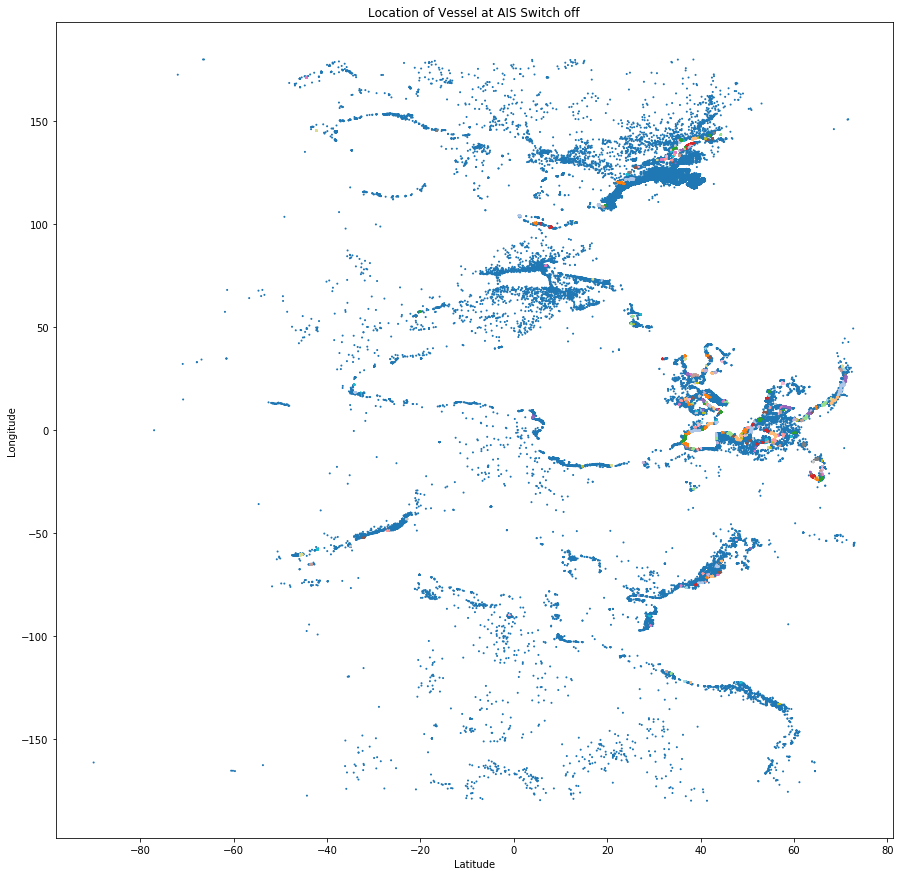

In [146]:
plt.figure(figsize=(15, 15))
plt.scatter(latlon_off['off_lat'], latlon_off['off_lon'], c=dbscan.labels_, s=1, cmap="tab20")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Location of Vessel at AIS Off');

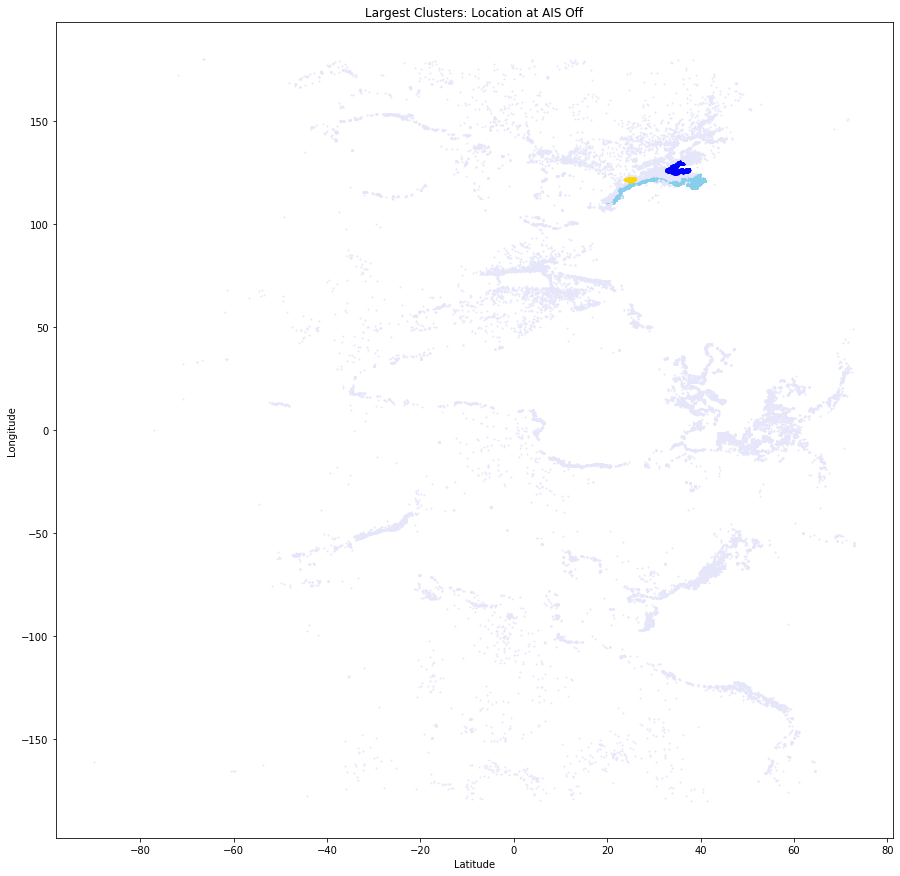

In [158]:
# Break top 3 clusters into dataframes and visualize (including noise)

cluster0 = latlon_off[latlon_off['off_cluster'] == 0]
cluster_1 = latlon_off[latlon_off['off_cluster'] == -1]
cluster11 = latlon_off[latlon_off['off_cluster'] == 11]
cluster18 = latlon_off[latlon_off['off_cluster'] == 18]

plt.figure(figsize=(15, 15))

plt.scatter(cluster0['off_lat'], cluster0['off_lon'], s=1, c='skyblue');
plt.scatter(cluster_1['off_lat'], cluster_1['off_lon'], s=1, c='lavender');
plt.scatter(cluster11['off_lat'], cluster11['off_lon'], s=1, c='b')
plt.scatter(cluster18['off_lat'], cluster18['off_lon'], s=1, c='gold')
plt.title('Largest Clusters: Location at AIS Off')
plt.xlabel('Latitude')
plt.ylabel('Longitude');

## Add Predictions to Dataset

In [186]:
# Merge cluster into the original dataframe
gap_notreg = gap_notreg.merge(latlon_off, how='outer', left_index=True, right_index=True)

# Drop the additional lat/lon columns
gap_notreg.drop(columns=['off_lat_y', 'off_lon_y'], inplace=True)

In [187]:
# Rename columns
gap_notreg.rename(columns={'off_lat_x' : 'off_lat',
                           'off_lon_x' : 'off_lon'}, inplace=True)

In [213]:
# Explore any patterns in the first few clusters
gap_notreg.groupby('off_cluster')[['gap_hours', 
                                   'gap_distance_m',
                                   'positions_per_day', 
                                   'on_distance_from_shore_m',
                                   'off_distance_from_shore_m',]].mean().T.loc[:,[0,11,18]]

off_cluster,0,11,18
gap_hours,148.705169,83.722995,80.574336
gap_distance_m,27228.560528,23273.283095,19232.774476
positions_per_day,9.574708,4.699112,7.267717
on_distance_from_shore_m,11756.614289,8941.377263,7088.922381
off_distance_from_shore_m,10747.771298,7746.710201,6278.372268


In [190]:
# Break into individual dataframes
cluster0 = gap_notreg[gap_notreg['off_cluster'] == 0]
cluster11 = gap_notreg[gap_notreg['off_cluster'] == 11]
cluster18 = gap_notreg[gap_notreg['off_cluster'] == 18]

# EDA on Cluster 0

- Total Observations: 208,866
- Unique Vessels (MMSI): 30,297
- Avg Length of Gaps: 148.70 hrs
- Avg Num Positions per Day: 9.57

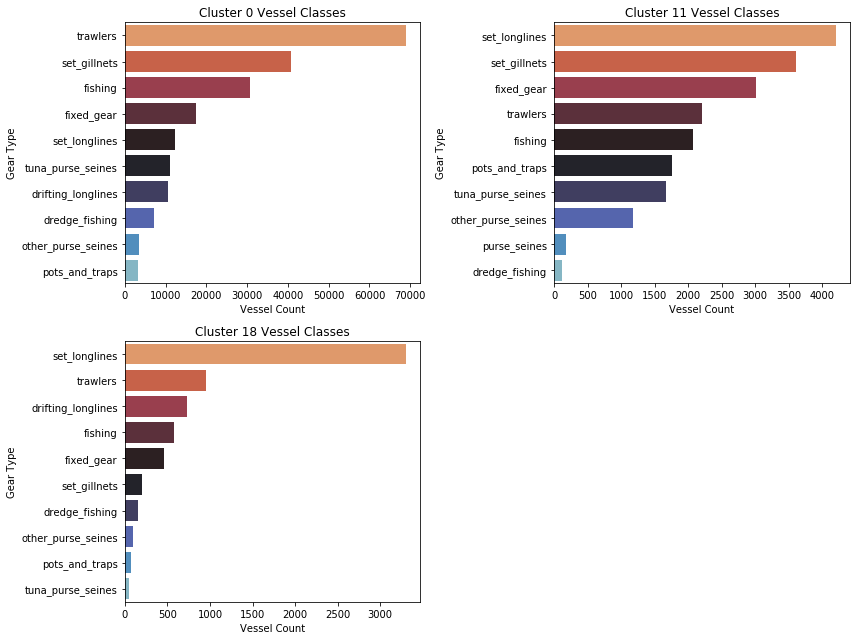

In [262]:
# Which vessel classes appear the most in cluster 0 and how often?

plt.figure(figsize=(12,9)) 

plt.subplot(2,2,1)
sns.countplot(y="vessel_class", 
              data=cluster0, 
              palette="icefire_r",
              order=cluster0['vessel_class'].value_counts().iloc[:10].index).set(title=('Cluster 0 Vessel Classes'),
                                                                                 xlabel=('Vessel Count'),
                                                                                 ylabel=('Gear Type'))
plt.subplot(2,2,2)
sns.countplot(y="vessel_class", 
              data=cluster11, 
              palette="icefire_r",
              order=cluster11['vessel_class'].value_counts().iloc[:10].index).set(title=('Cluster 11 Vessel Classes'),
                                                                                 xlabel=('Vessel Count'),
                                                                                 ylabel=('Gear Type'))
plt.subplot(2,2,3)
sns.countplot(y="vessel_class", 
              data=cluster18, 
              palette="icefire_r",
              order=cluster18['vessel_class'].value_counts().iloc[:10].index).set(title=('Cluster 18 Vessel Classes'),
                                                                                 xlabel=('Vessel Count'),
                                                                                 ylabel=('Gear Type'))
plt.tight_layout();

In [223]:
# Which countries have the highest average gaps
cluster0.groupby('flag')['gap_hours'].mean().sort_values(ascending=False)

flag
SLE        2266.116667
SLB        1287.233333
GUF         685.583333
DZA         469.183333
GIN         359.083333
ALB         268.421111
Unknown     263.110511
KOR         210.482407
BHR         154.500000
CHN         148.587277
TWN         133.209923
HKG          97.436364
RUS          92.197917
JPN          65.005814
MNG          54.794444
MRT          53.588889
VNM          51.500000
WSM          48.766667
PAN          27.683333
GMB          17.966667
MUS          14.033333
Name: gap_hours, dtype: float64

In [224]:
# Which vessels have the highest avg gaps and where are they from?
cluster0.groupby(['mmsi','flag','vessel_class'])['gap_hours'].mean().sort_values(ascending=False)

mmsi       flag  vessel_class      
412131188  CHN   set_gillnets          15511.116667
654321     CHN   drifting_longlines    13818.050000
412563566  CHN   fishing               13550.200000
412365155  CHN   fishing               13508.366667
412214256  CHN   set_gillnets          11494.450000
                                           ...     
412418708  CHN   trawlers                 12.100000
113449991  CHN   tuna_purse_seines        12.066667
412378069  CHN   trawlers                 12.050000
413238388  CHN   set_gillnets             12.016667
412286068  CHN   trawlers                 12.000000
Name: gap_hours, Length: 30297, dtype: float64

In [273]:
# Are there any relationships between location and the length of the gap event?
# Within cluster 0 zoom in on the gaps lasting less 1000 hours

def gaps_scatter(cluster):
    low_gaps = cluster[cluster['gap_hours'] < 1000]
    return low_gaps.plot(kind="scatter", 
                  x="off_lat",
                  y="off_lon", 
                  c="gap_hours",
                  cmap="icefire_r", 
                  figsize=(14, 10), 
                  s=4, 
                  title='Length of Gap Events by Location')

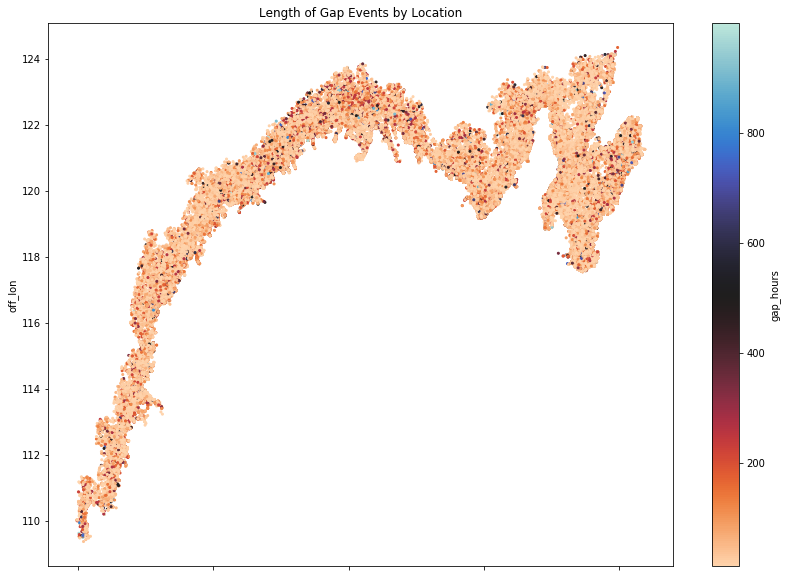

In [275]:
gaps_scatter(cluster0);

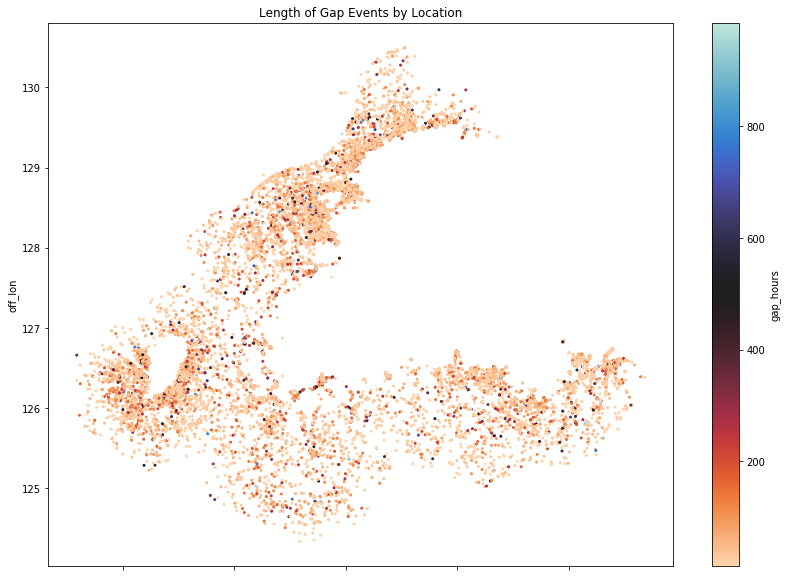

In [276]:
gaps_scatter(cluster11);

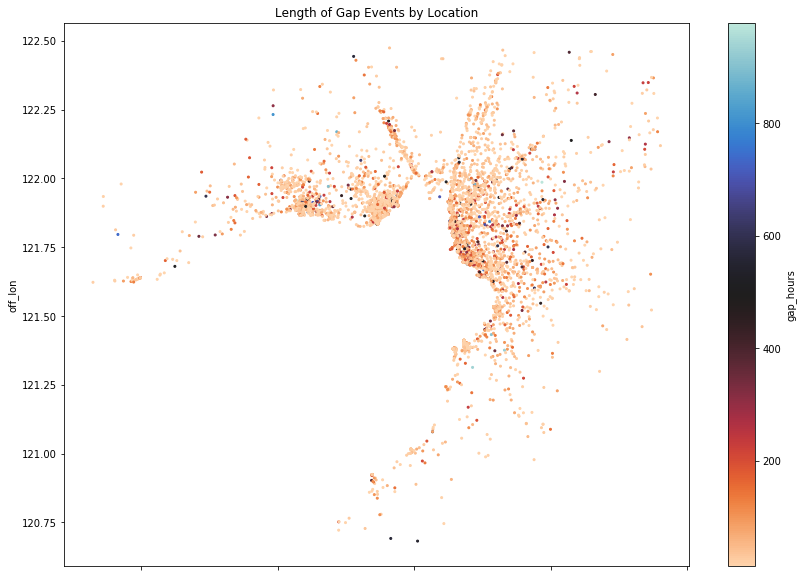

In [277]:
gaps_scatter(cluster18);

In [ ]:
# When did the highest number of gap events take place?


In [222]:
# check the distribution of gap hours

# high_gaps = gap_notreg[gap_notreg['gap_hours'] > 2000]
# low_gaps = gap_notreg[gap_notreg['gap_hours'] < 2000]

# plt.figure(figsize=(18,6))
# sns.distplot(low_gaps['gap_hours']).set(xlabel='Number of Hours off Radar', 
#                                         ylabel='Number of Vessels', 
#                                         title='Gap Hr Distribution (Under 2000 hrs)');

In [8]:
# save to csv
gap_notreg.to_csv('./data/gap_notreg.csv', index=False)

# References
- https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
- https://link.springer.com/chapter/10.1007/978-3-030-38081-6_2